In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict
from konlpy.tag import Okt

# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 사용 데이터 불러오기
df = pd.read_csv("../01_데이터수집/비정형데이터/faxnet_21/팍스넷_21대_대선_테마주_크롤링_20250627.csv")
positive_df = pd.read_csv("../03_모델링/sentiment_dictionary/final_positive_dict.csv")
negative_df = pd.read_csv("../03_모델링/sentiment_dictionary/final_negative_dict.csv")

In [ ]:
# 감성 사전 구성 (key: 단어, value: 최종점수)
positive_dict = dict(zip(positive_df["단어"], positive_df["최종점수"]))
negative_dict = dict(zip(negative_df["단어"], negative_df["최종점수"]))
sentiment_dict = {**positive_dict, **negative_dict}

# datetime 변환
df["날짜"] = pd.to_datetime(df["날짜"])

# 종목별, 날짜별 감성 점수 누적 저장 딕셔너리
stock_sentiment_by_date = defaultdict(lambda: defaultdict(float))

# 각 행에 대해 점수 계산
for _, row in df.iterrows():
    stock = row["종목명"]
    date = row["날짜"].date()
    text = f"{row['제목']} {row['내용']}"
    words = set(Okt().morphs(text))  # 형태소 기준 중복 제거
    total_score = sum(sentiment_dict[word] for word in words if word in sentiment_dict)
    stock_sentiment_by_date[stock][date] += total_score

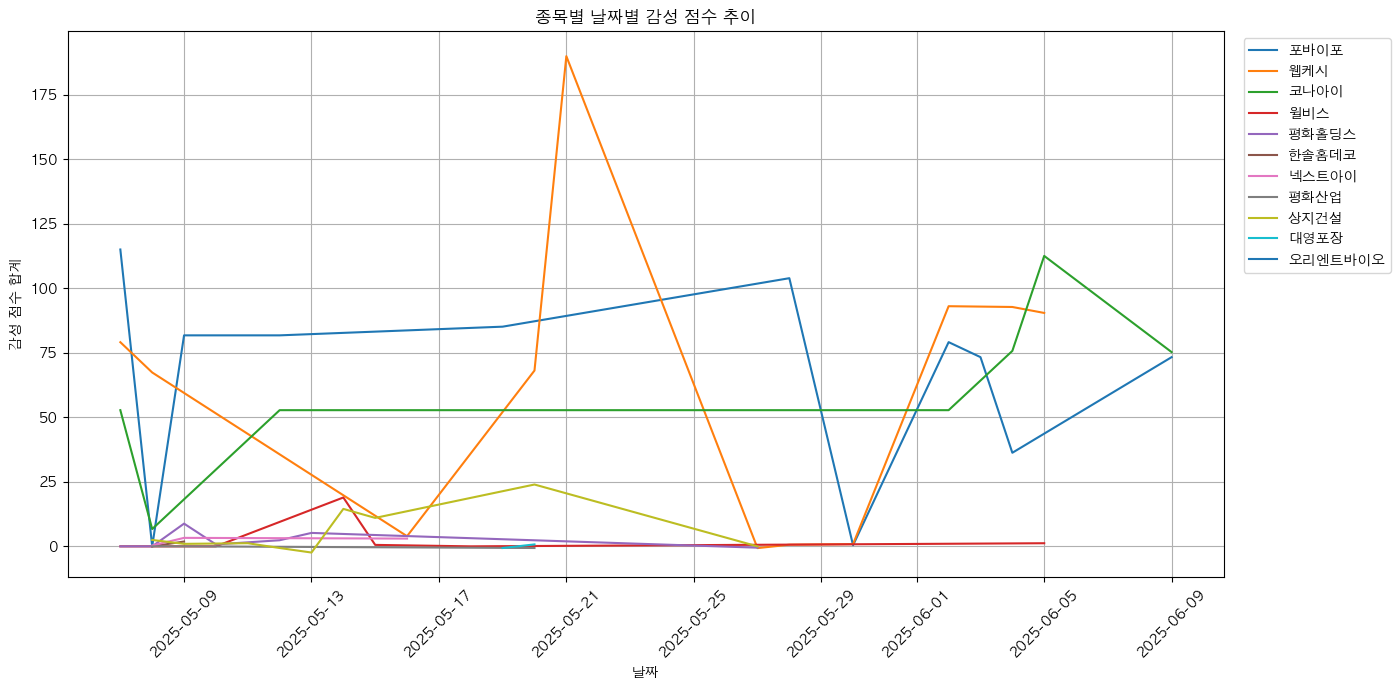

In [ ]:
# 시각화
fig, ax = plt.subplots(figsize=(14, 7))

for stock, date_scores in stock_sentiment_by_date.items():
    sorted_dates = sorted(date_scores)
    scores = [date_scores[date] for date in sorted_dates]
    ax.plot(sorted_dates, scores, label=stock)

ax.set_xlabel("날짜")
ax.set_ylabel("감성 점수 합계")
ax.set_title("종목별 날짜별 감성 점수 추이")
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

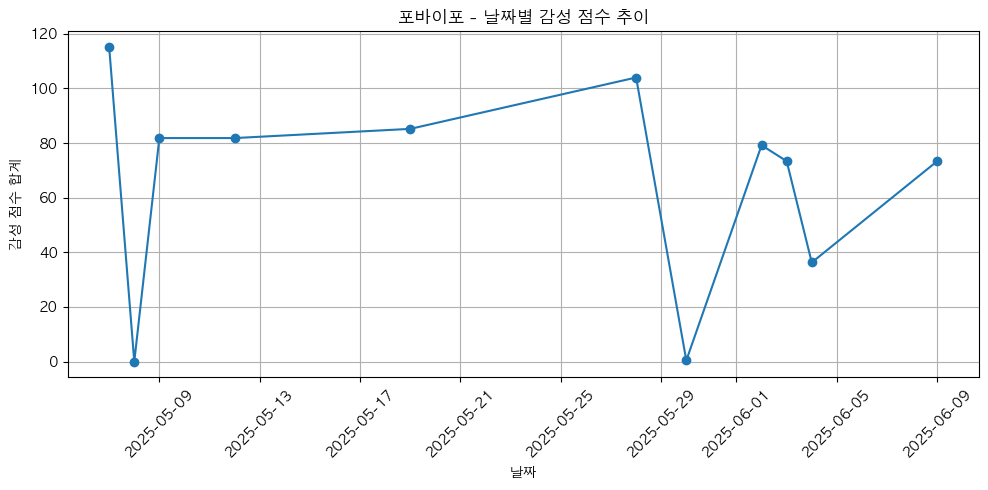

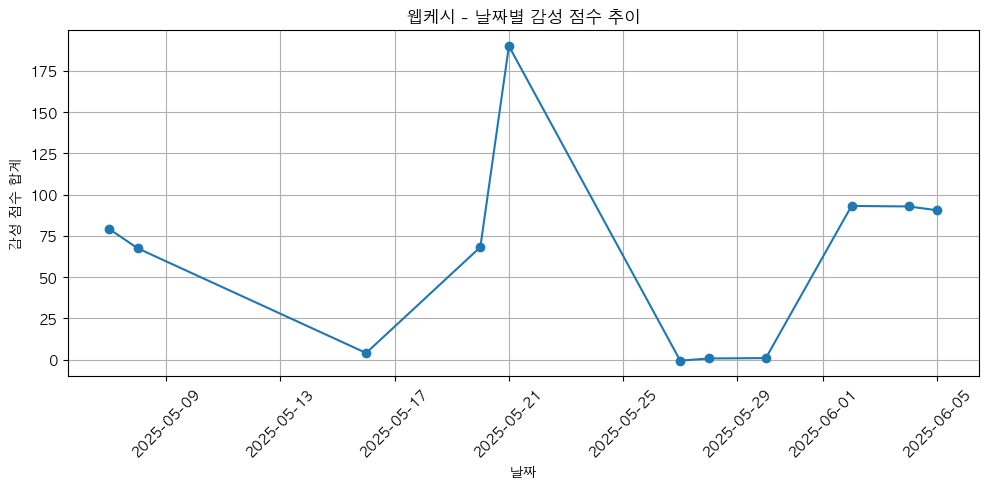

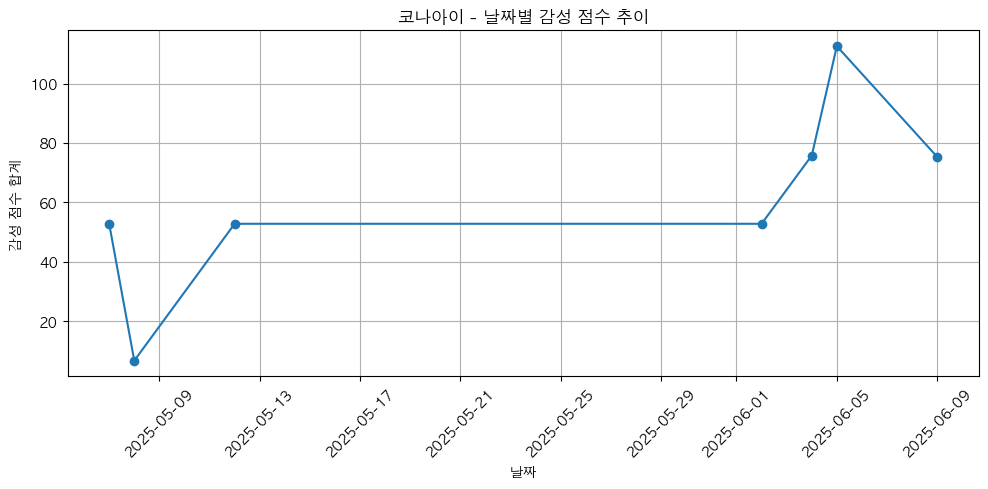

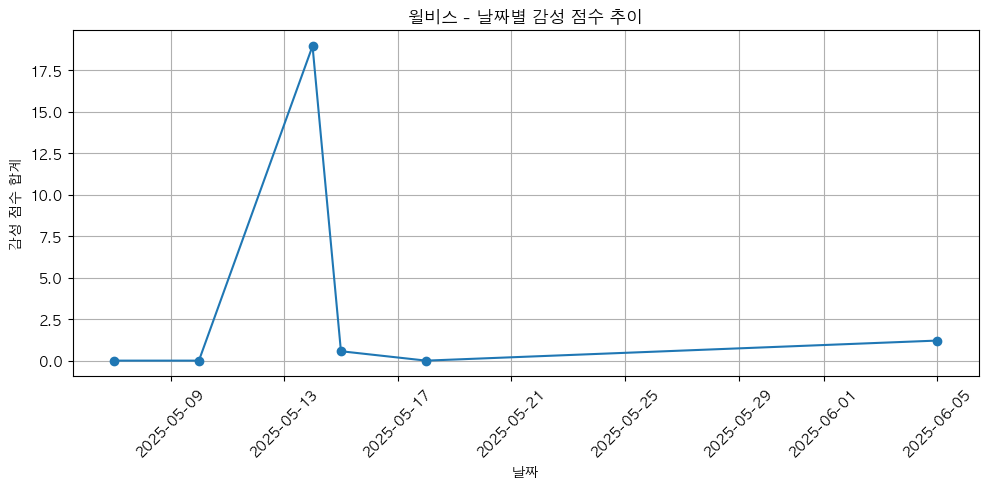

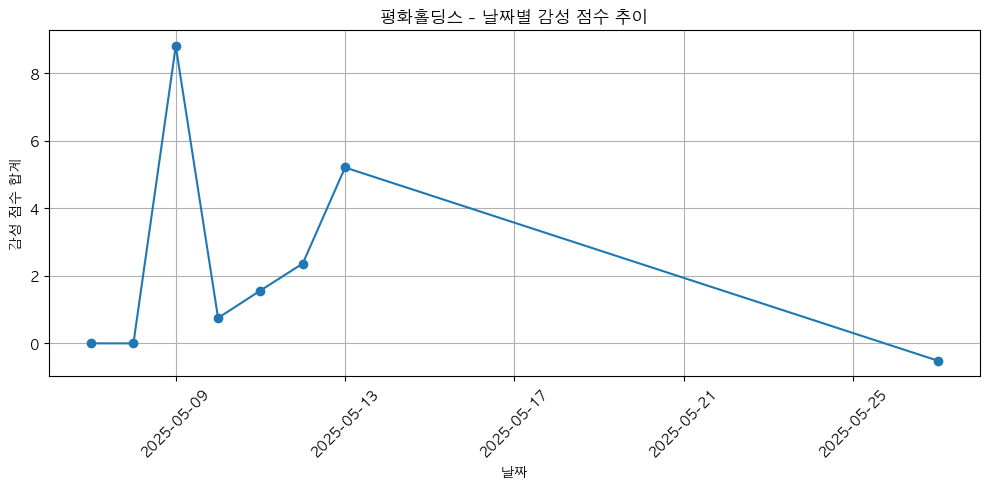

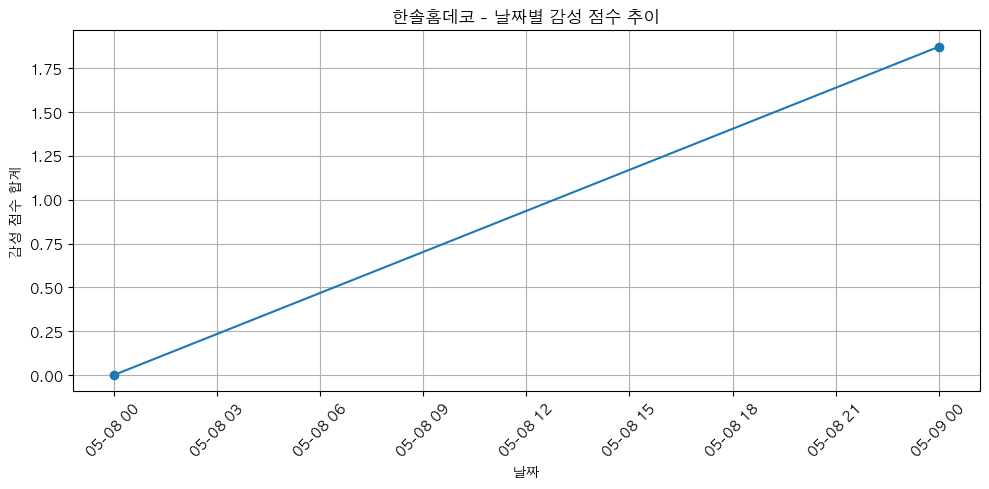

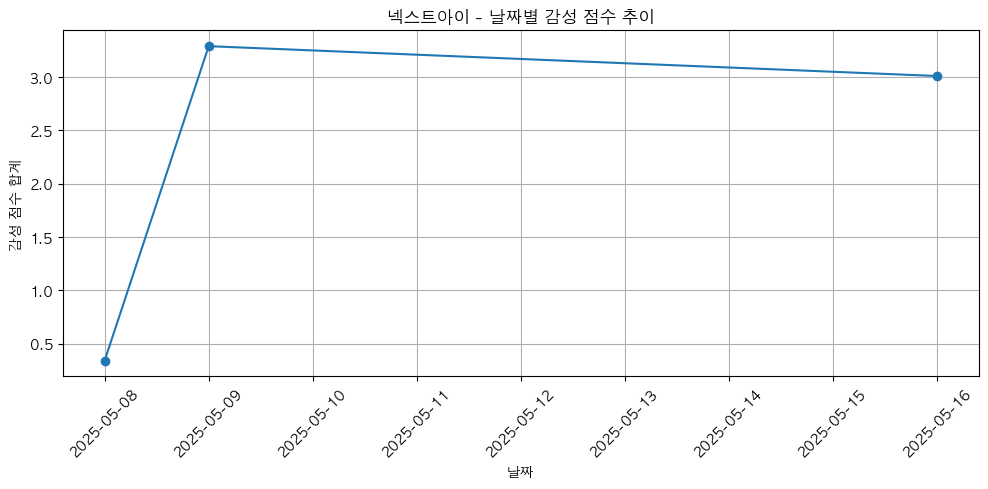

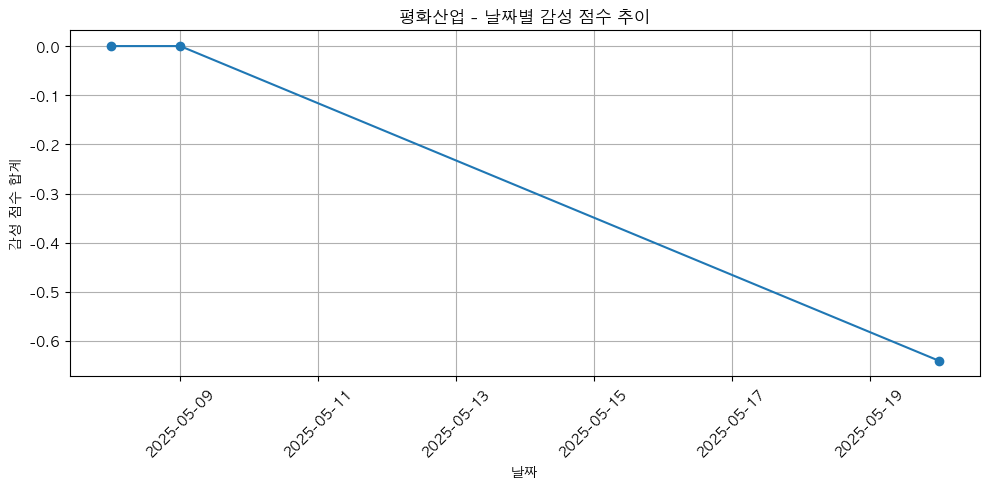

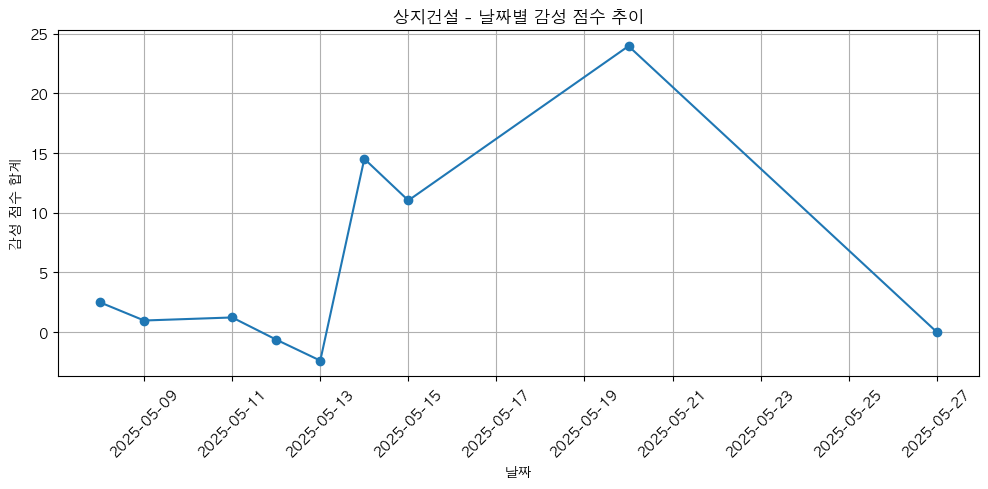

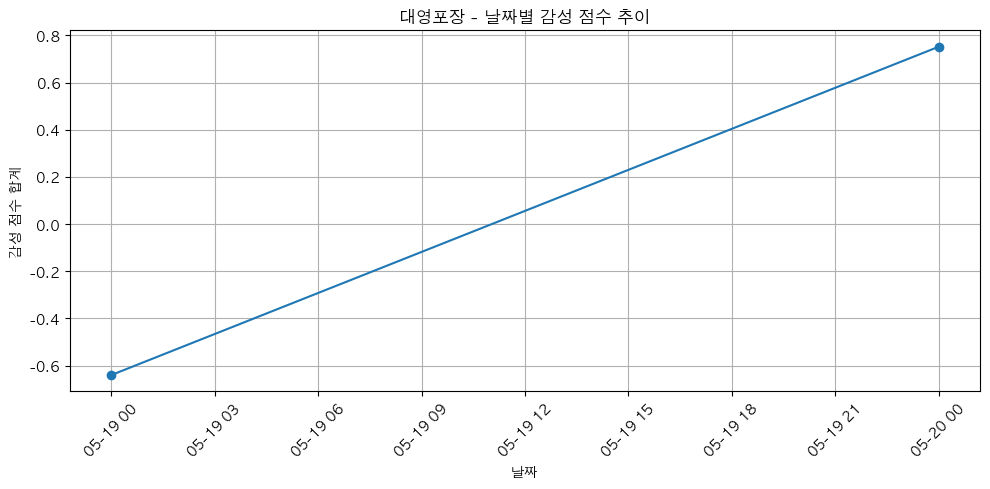

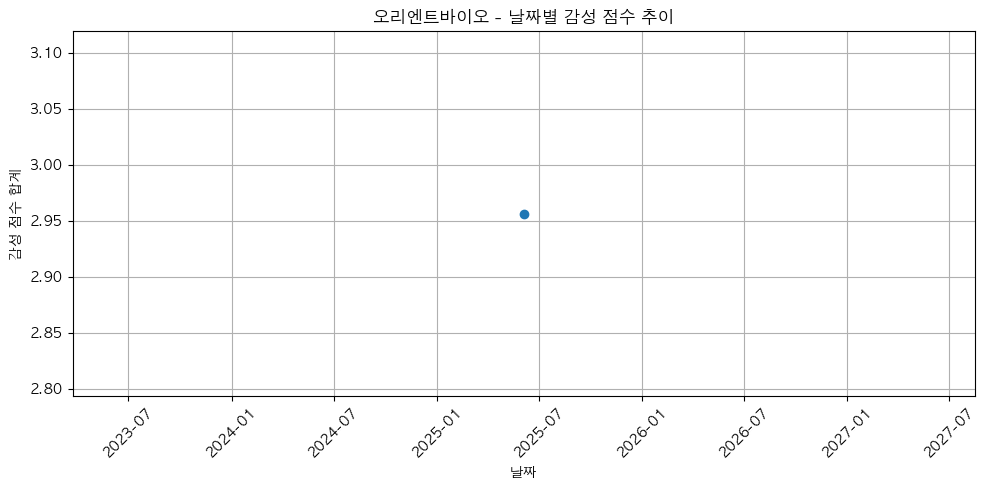

In [ ]:
# 종목별로 확인
for stock, date_scores in stock_sentiment_by_date.items():
    sorted_dates = sorted(date_scores)
    scores = [date_scores[date] for date in sorted_dates]

    plt.figure(figsize=(10, 5))
    plt.plot(sorted_dates, scores, marker='o')
    plt.title(f"{stock} - 날짜별 감성 점수 추이")
    plt.xlabel("날짜")
    plt.ylabel("감성 점수 합계")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()